# 1.14a: Token Escape Dynamics

**Goal:** Visualize how tokens escape from the black hole over training.

## Coordinate System

We use a **comoving reference frame** where the black hole is always at the origin:
- **Black hole center:** Centroid of untrained tokens at each timestep
- **Distance:** L2 norm from black hole center (not global centroid)
- This factors out bulk motion and shows true escape dynamics

## Visualization

- **Y-axis:** Training step (time flows upward)
- **X-axis:** L2 distance from black hole center
- **Traces:** One per token (colored by trained/untrained status)

## Questions to Answer

1. Do trained tokens **explode** out instantly or **drift** gradually?
2. Do untrained tokens stay frozen at the origin (in comoving frame)?
3. What's the timescale of dispersion?
4. Do tokens move individually or in groups?

## Input

Training data from any training run (e.g., 1.12a, 1.12b) containing:
- `embeddings`: (n_steps, vocab_size, hidden_dim)
- Optional: token usage data to identify trained/untrained

## Parameters

In [5]:
# Training data to analyze
TRAINING_DATA_PATH = "../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors"

# Corpus path (to identify trained vs untrained tokens)
CORPUS_PATH = "../data/fineweb_ascii.txt"

# Visualization
PLOT_DPI = 150
COLORMAP_TRAINED = 'viridis'    # Color scheme for trained tokens
COLORMAP_UNTRAINED = 'Reds'     # Color scheme for untrained tokens
ALPHA = 0.6                      # Transparency for traces

## Imports

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import load_file

print("✓ Imports complete")

✓ Imports complete


## Load Training Data

In [7]:
print(f"Loading training data: {TRAINING_DATA_PATH}\n")

data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings'].float()  # (n_steps, vocab_size, hidden_dim)

n_steps, vocab_size, hidden_dim = embeddings.shape

print(f"✓ Loaded training data")
print(f"  Shape: {embeddings.shape}")
print(f"  Steps: {n_steps:,}")
print(f"  Vocab: {vocab_size}")
print(f"  Hidden dim: {hidden_dim}")

Loading training data: ../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors

✓ Loaded training data
  Shape: torch.Size([50001, 128, 64])
  Steps: 50,001
  Vocab: 128
  Hidden dim: 64


## Identify Trained vs Untrained Tokens

In [8]:
print(f"\nAnalyzing corpus: {CORPUS_PATH}\n")

# Read corpus and find which tokens appear
with open(CORPUS_PATH, 'r', encoding='ascii') as f:
    corpus_text = f.read()

corpus_bytes = corpus_text.encode('ascii')
trained_tokens = sorted(set(corpus_bytes))
untrained_tokens = sorted(set(range(vocab_size)) - set(trained_tokens))

print(f"✓ Identified token usage")
print(f"  Trained: {len(trained_tokens)} tokens")
print(f"  Untrained: {len(untrained_tokens)} tokens")
print(f"  Ratio: {len(trained_tokens)}/{vocab_size} ({100*len(trained_tokens)/vocab_size:.1f}%)")


Analyzing corpus: ../data/fineweb_ascii.txt

✓ Identified token usage
  Trained: 94 tokens
  Untrained: 34 tokens
  Ratio: 94/128 (73.4%)


## Compute Centroid at Each Timestep

In [9]:
print(f"\nComputing black hole centroid (untrained tokens only)...\n")

# Black hole center = centroid of untrained tokens at each timestep
# This defines our comoving reference frame
untrained_indices = torch.tensor(untrained_tokens, dtype=torch.long)
black_hole_centers = embeddings[:, untrained_indices, :].mean(dim=1)  # (n_steps, hidden_dim)

print(f"✓ Computed black hole trajectory")
print(f"  Shape: {black_hole_centers.shape}")
print(f"  Reference frame: {len(untrained_tokens)} untrained tokens")
print(f"  BH center norm at step 0: {torch.norm(black_hole_centers[0]).item():.6f}")
print(f"  BH center norm at step {n_steps-1}: {torch.norm(black_hole_centers[-1]).item():.6f}")


Computing black hole centroid (untrained tokens only)...

✓ Computed black hole trajectory
  Shape: torch.Size([50001, 64])
  Reference frame: 34 untrained tokens
  BH center norm at step 0: 0.029190
  BH center norm at step 50000: 0.641019


## Compute Distance from Centroid for Each Token

In [10]:
print(f"\nComputing token distances from black hole center...\n")

# For each token at each timestep, compute L2 distance from black hole center
# embeddings: (n_steps, vocab_size, hidden_dim)
# black_hole_centers: (n_steps, hidden_dim)

# Broadcast black hole center to match embeddings shape
bh_centers_expanded = black_hole_centers.unsqueeze(1)  # (n_steps, 1, hidden_dim)

# Compute L2 distance for each token from BH center
distances = torch.norm(embeddings - bh_centers_expanded, p=2, dim=2)  # (n_steps, vocab_size)

print(f"✓ Computed distances from black hole")
print(f"  Shape: {distances.shape}")
print(f"  Distance range at step 0: [{distances[0].min().item():.6f}, {distances[0].max().item():.6f}]")
print(f"  Distance range at step {n_steps-1}: [{distances[-1].min().item():.6f}, {distances[-1].max().item():.6f}]")
print()
print(f"  Untrained token distances at step {n_steps-1}:")
print(f"    Mean: {distances[-1, untrained_indices].mean().item():.6e} (should be ~0)")
print(f"    Max: {distances[-1, untrained_indices].max().item():.6e}")


Computing token distances from black hole center...

✓ Computed distances from black hole
  Shape: torch.Size([50001, 128])
  Distance range at step 0: [0.129965, 0.198058]
  Distance range at step 50000: [0.084358, 1.411195]

  Untrained token distances at step 50000:
    Mean: 1.071036e-01 (should be ~0)
    Max: 1.423110e-01


## Plot: Token Escape Dynamics


Plotting token escape dynamics (comoving frame)...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_24740/3110311848.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_trained = plt.cm.get_cmap(COLORMAP_TRAINED)
/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_24740/3110311848.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_untrained = plt.cm.get_cmap(COLORMAP_UNTRAINED)


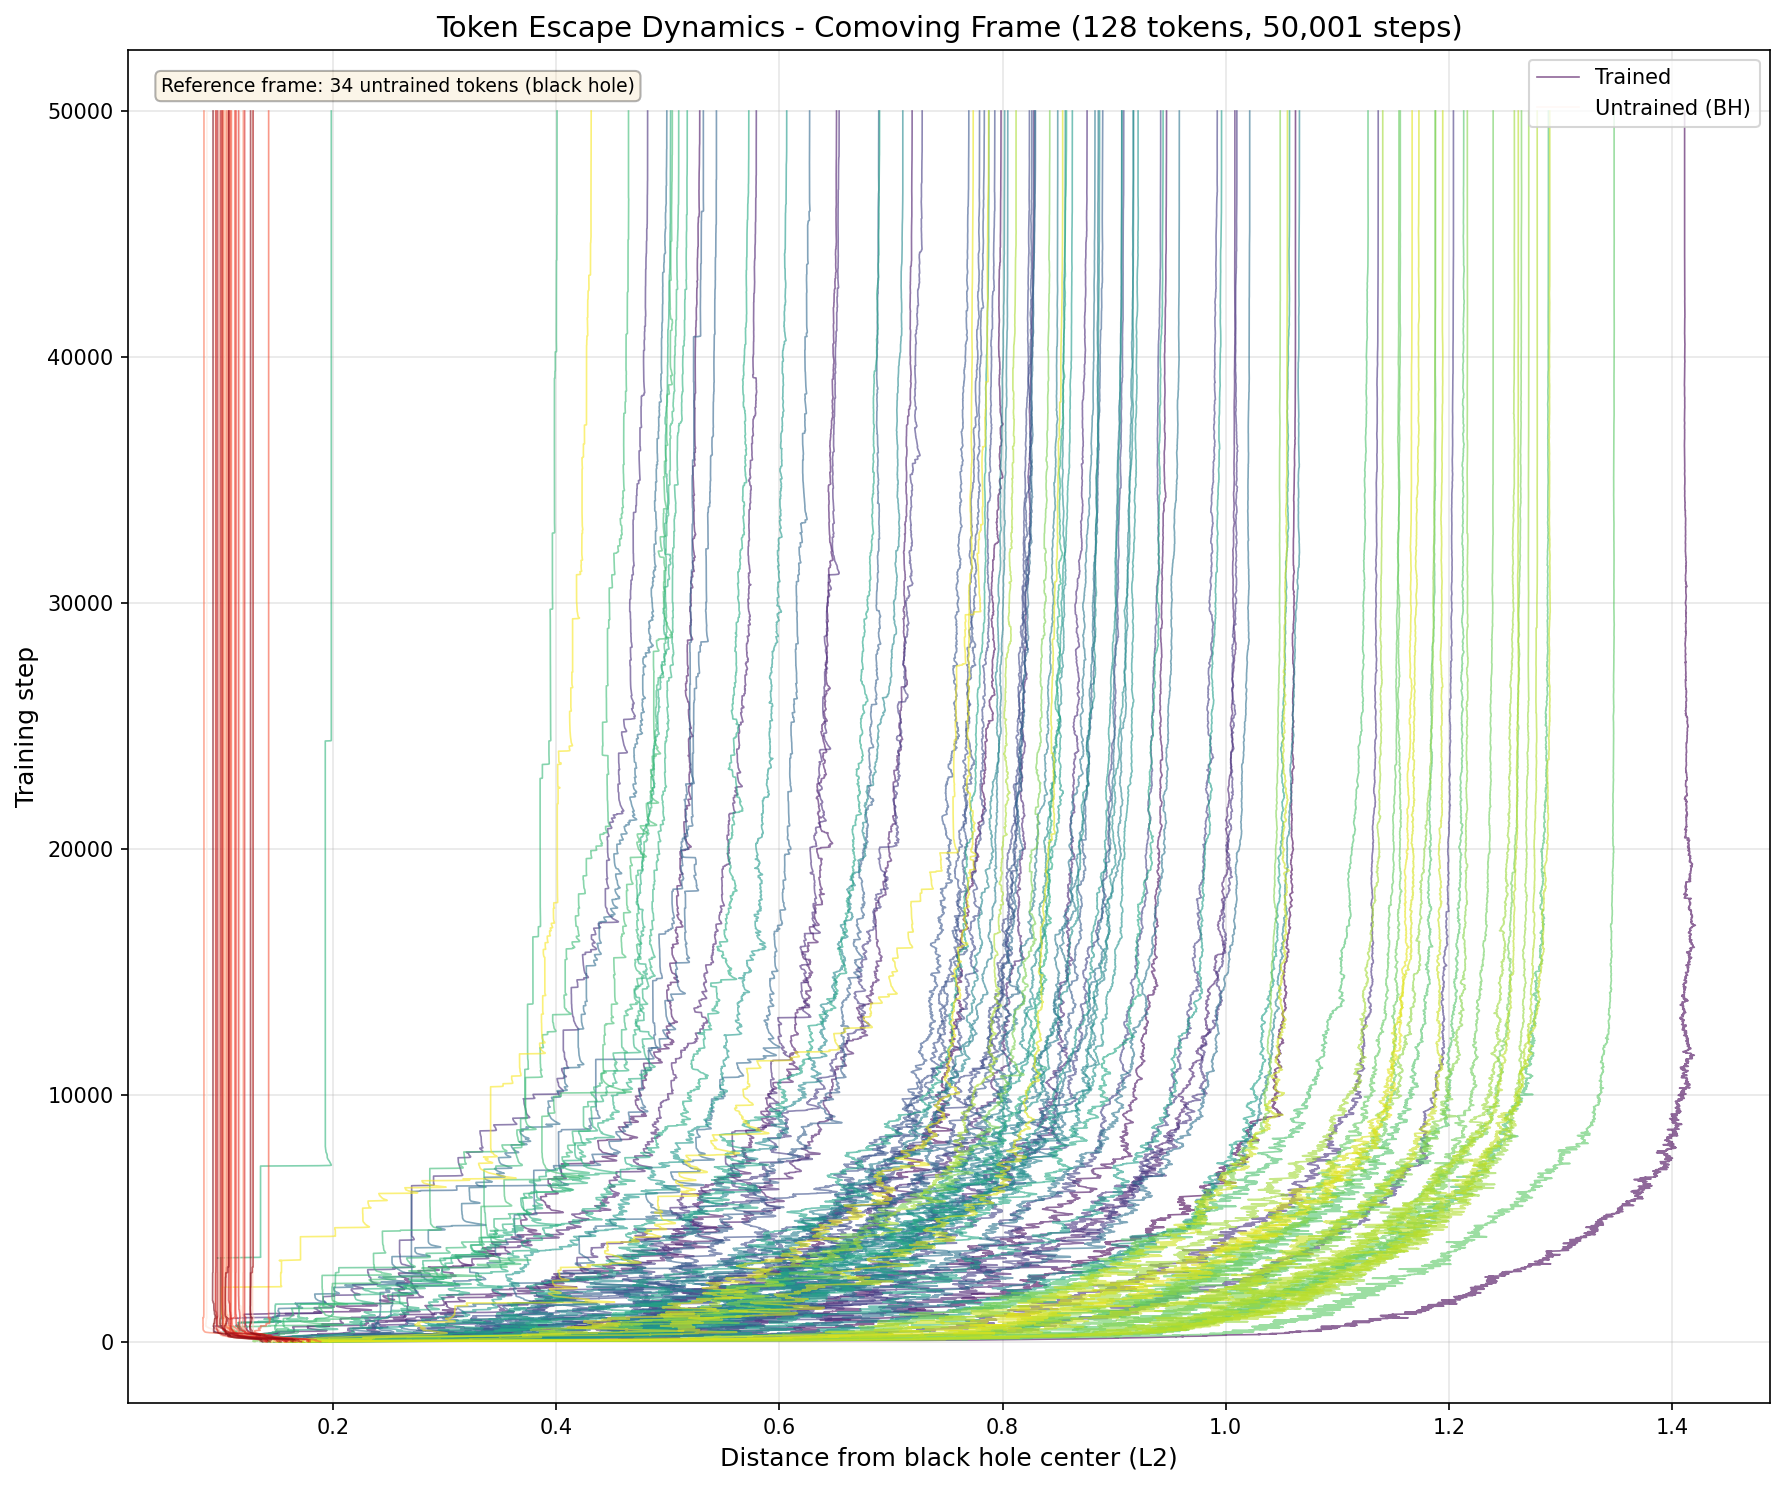

✓ Visualization complete


In [11]:
print(f"\nPlotting token escape dynamics (comoving frame)...\n")

fig, ax = plt.subplots(figsize=(12, 10), dpi=PLOT_DPI)

# Time axis (steps)
steps = np.arange(n_steps)

# Plot trained tokens
cmap_trained = plt.cm.get_cmap(COLORMAP_TRAINED)
for i, token_id in enumerate(trained_tokens):
    color = cmap_trained(i / len(trained_tokens))
    ax.plot(distances[:, token_id].numpy(), steps, 
            color=color, alpha=ALPHA, linewidth=0.8, 
            label='Trained' if i == 0 else None)

# Plot untrained tokens
cmap_untrained = plt.cm.get_cmap(COLORMAP_UNTRAINED)
for i, token_id in enumerate(untrained_tokens):
    color = cmap_untrained(i / max(1, len(untrained_tokens)))
    ax.plot(distances[:, token_id].numpy(), steps, 
            color=color, alpha=ALPHA, linewidth=0.8,
            label='Untrained (BH)' if i == 0 else None)

# Styling
ax.set_xlabel('Distance from black hole center (L2)', fontsize=12)
ax.set_ylabel('Training step', fontsize=12)
ax.set_title(f'Token Escape Dynamics - Comoving Frame ({vocab_size} tokens, {n_steps:,} steps)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', fontsize=10)

# Add annotation about reference frame
ax.text(0.02, 0.98, f'Reference frame: {len(untrained_tokens)} untrained tokens (black hole)', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

ax.set_yscale('linear')
# ax.set_xlim(0, 0.2)
# ax.set_ylim(0, 400)

plt.tight_layout()
plt.show()

print(f"✓ Visualization complete")

## Statistics: Escape Timeline

In [12]:
print(f"\n{'='*80}")
print(f"ESCAPE STATISTICS")
print(f"{'='*80}\n")

# Define "escaped" as distance > some threshold (e.g., 0.01)
ESCAPE_THRESHOLD = 0.01

# For each token, find first step where it exceeds threshold
escape_steps = []
for token_id in range(vocab_size):
    escaped = torch.where(distances[:, token_id] > ESCAPE_THRESHOLD)[0]
    if len(escaped) > 0:
        escape_steps.append((token_id, escaped[0].item()))

# Separate by trained/untrained
trained_escapes = [(tid, step) for tid, step in escape_steps if tid in trained_tokens]
untrained_escapes = [(tid, step) for tid, step in escape_steps if tid in untrained_tokens]

print(f"Escape threshold: {ESCAPE_THRESHOLD}")
print()
print(f"Trained tokens:")
if trained_escapes:
    escape_times = [step for _, step in trained_escapes]
    print(f"  Escaped: {len(trained_escapes)} / {len(trained_tokens)}")
    print(f"  First escape: step {min(escape_times)}")
    print(f"  Last escape: step {max(escape_times)}")
    print(f"  Median escape: step {int(np.median(escape_times))}")
else:
    print(f"  No trained tokens escaped threshold")

print()
print(f"Untrained tokens:")
if untrained_escapes:
    escape_times = [step for _, step in untrained_escapes]
    print(f"  Escaped: {len(untrained_escapes)} / {len(untrained_tokens)}")
    print(f"  First escape: step {min(escape_times)}")
    print(f"  Last escape: step {max(escape_times)}")
    print(f"  Median escape: step {int(np.median(escape_times))}")
else:
    print(f"  No untrained tokens escaped threshold")

print()
print(f"Final distances (step {n_steps-1}):")
trained_final = distances[-1, trained_tokens]
untrained_final = distances[-1, untrained_tokens]
print(f"  Trained: mean={trained_final.mean().item():.4f}, std={trained_final.std().item():.4f}")
print(f"  Untrained: mean={untrained_final.mean().item():.4f}, std={untrained_final.std().item():.4f}")

print()
print(f"{'='*80}")


ESCAPE STATISTICS

Escape threshold: 0.01

Trained tokens:
  Escaped: 94 / 94
  First escape: step 0
  Last escape: step 0
  Median escape: step 0

Untrained tokens:
  Escaped: 34 / 34
  First escape: step 0
  Last escape: step 0
  Median escape: step 0

Final distances (step 50000):
  Trained: mean=0.8880, std=0.2556
  Untrained: mean=0.1071, std=0.0123



## Summary

In [13]:
print(f"\n{'='*80}")
print(f"SUMMARY")
print(f"{'='*80}\n")
print(f"Analyzed: {TRAINING_DATA_PATH}")
print(f"  Steps: {n_steps:,}")
print(f"  Tokens: {vocab_size} ({len(trained_tokens)} trained, {len(untrained_tokens)} untrained)")
print()
print(f"Observations:")
print(f"  → Check plot to see escape dynamics")
print(f"  → Do trained tokens explode or drift?")
print(f"  → Do untrained tokens stay frozen?")
print(f"  → What's the dispersion timescale?")
print()
print(f"{'='*80}")


SUMMARY

Analyzed: ../tensors/Lil_Gatsby/1.12a_training_data_default_init_50000.safetensors
  Steps: 50,001
  Tokens: 128 (94 trained, 34 untrained)

Observations:
  → Check plot to see escape dynamics
  → Do trained tokens explode or drift?
  → Do untrained tokens stay frozen?
  → What's the dispersion timescale?

